In [1]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.Variational import MeanFieldVariationalDistribution
from Inference.VariationalAE import MeanFieldVariationalAE
from Tools.NNtools import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Target density #

In [3]:
target_component = [torch.distributions.normal.Normal(-1.0, 0.2),
           torch.distributions.normal.Normal(1.0, 0.2)]
     #      torch.distributions.normal.Normal(-5.0, 0.2)]
target_proportions = torch.tensor([0.5, 0.5,
                                  ])#0.20])

In [4]:
def target(x):
    return torch.exp(logtarget(x))

def logtarget(x):
    logp = [None]*len(target_component)
    for j in range(len(target_component)):
        logp[j] = target_component[j].log_prob(x) + target_proportions[j].log()
    return torch.logsumexp(torch.cat(logp,dim=1),dim=1).unsqueeze(-1)



<IPython.core.display.Javascript object>


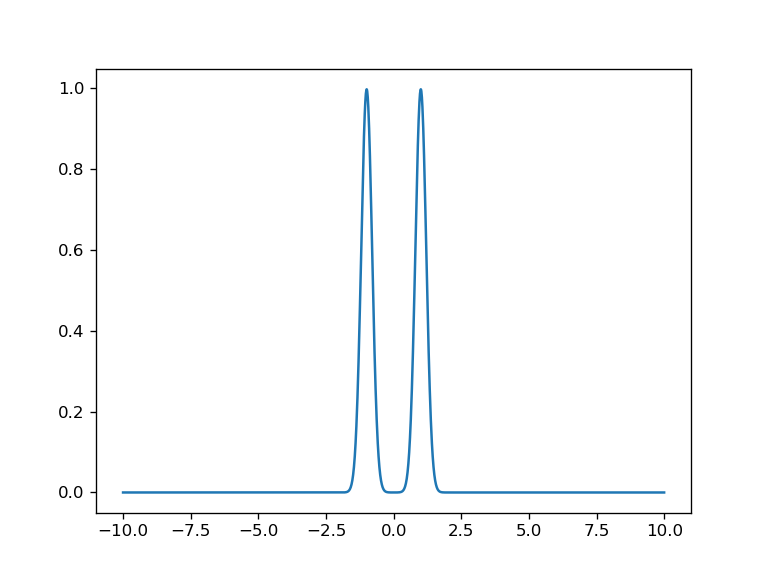

In [5]:
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
Z = (1/(torch.sum(target(x_lin),dim=0)*0.01)).detach().cpu().numpy()
plt.plot(x_lin.detach().cpu().numpy(), Z*target(x_lin).detach().cpu().numpy())
plt.show()

# AE-Variational Distribution #

In [6]:
nb_latent=2
VAE = MeanFieldVariationalAE(nb_latent,4,1)
VAE_param_count = get_param(VAE).shape[0]
VAE_param_count

21

In [16]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
VAE.decoder.apply(init_weights)


Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=4, out_features=1, bias=True)
)

In [18]:
def KLDivGauss(mu,sigma):
    Div=sigma+mu**2-sigma.log()-1
    return 0.5*Div.sum().squeeze()

In [19]:
n_samples_VAR = 20

In [20]:
optimizer = torch.optim.Adam(VAE.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=30, factor=0.5)

In [21]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    
    Div = KLDivGauss(VAE.mfvar.mu,VAE.mfvar.sigma)
    
    LL=torch.Tensor(n_samples_VAR)
    for i in range(n_samples_VAR):
        theta = VAE()
        LL[i]=logtarget(theta)
    L = Div - LL.mean()

    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.0001:
        break

KeyboardInterrupt: 

In [ ]:
L

<IPython.core.display.Javascript object>


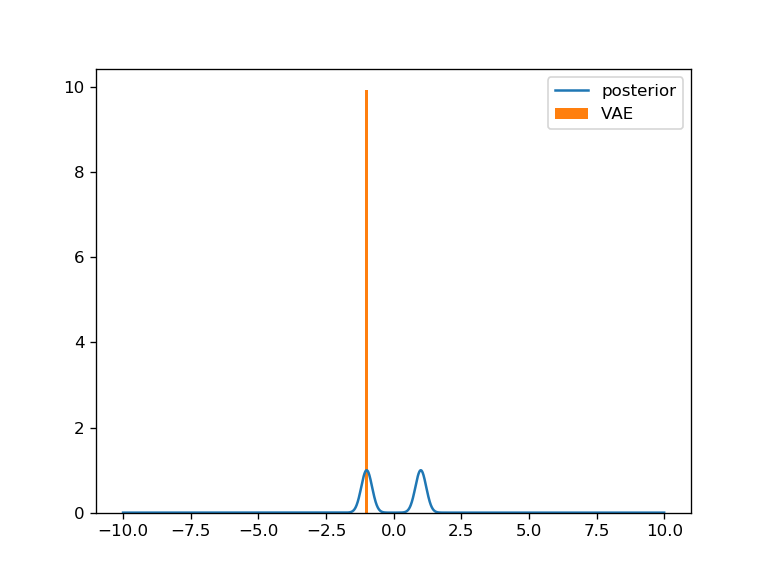

In [22]:
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)

Z = (1/(torch.sum(target(x_lin),dim=0)*0.01)).detach().cpu().numpy()
plt.plot(x_lin.detach().cpu().numpy(), Z*target(x_lin).detach().cpu().numpy())

Z = []
for i in range(5000):
    z = VAE()
    Z.append(z.detach().clone().cpu().squeeze().numpy())

#plt.ylim(0, 5) 
plt.hist(np.stack(Z),bins=1,density=True);
plt.legend(['posterior', 'VAE'])
